## Sequence to Sequence Learning with Neural Networks

## Introduction

The most common sequence-to-sequence (seq2seq) models are encoder-decoder models,<br> which commonly use a recurrent neural network (RNN) to encode the source (input)<br> sentence into a single vector.

We refer to this single vector (Output from the encoder block) as a context vector.<br> We can think of the context vector as being an abstract representation<br> of the entire input sentence. This vector is then decoded by a second RNN which learns<br> to output the target (output) sentence by generating it one word at a time.

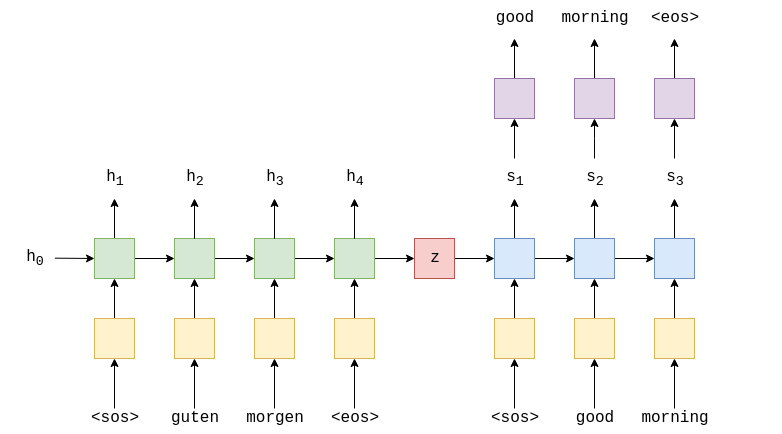

`sos` means `start of sentence` and `eos` means `end of sentence`.

In general,<br>
The operations happening in seq2seq models are:<br><br>
$$
h_t=EncoderRNN \left(e\left(x_t\right), h_{t-1}\right)
$$
<br><br>
$$
s_t=D e c o d e r R N N \left(d\left(y_t\right), s_{t-1}\right)
$$
<br><br>
$$
\hat{y}_t=f\left(s_t\right)
$$

## Preparing Data

Here, we will be creating a model to translate english language to german.

We'll be coding in PyTorch and using torchtext for pre-processing and spaCy to assist <br>tokenization of the data.

I will be using torchtext 0.6.0 because currently there is no stable torchtext.

In [1]:
!pip install -U torchtext==0.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Import necessary libraries

import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time

In [3]:
# Set random seeds for deterministic results
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Now, we need to generate tokens for the data.<br>
After tokenizing, "good morning !" becomes ["good", "morning", "!"].<br>
Each and every sentence is represented as sequence of tokens.<br><br>
`spaCy` has model for each language ("`de_core_news_sm`" for German and "`en_core_web_sm`" for English)<br> which need to be loaded so we can access the tokenizer of each model.

In [5]:
# Downloading the models
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

2023-06-22 16:29:13.974966: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 82.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
2023-06-22 16:29:28.524326: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 52.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


In [6]:
# Load the spaCy models (Models for tokenization)

spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

Next, we create the tokenizer functions. These can be passed to torchtext and will take <br> in the sentence as a string and return the sentence as a list of tokens.

In [10]:
doc = [tok.text for tok in spacy_en.tokenizer("This is a sentence!")]
doc

['This', 'is', 'a', 'sentence', '!']

In [11]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings (tokens) and reverses it
    """
    return [tok.text for tok in spacy_de.tokenizer(text)][::-1]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In the paper we are implementing, they find it beneficial to reverse the order of the input <br>which they believe "introduces many short term dependencies in the data that make the<br> optimization problem much easier". So, we reverse the German sentence after tokenization.

torchtext's `Field`s handle how data should be processed.

We set the `tokenize` argument to the correct tokenization function.<br>
Then we specify `init_token` as `<sos>`, `eos_token` as `<eos>` and set `lower = True`.

In [12]:
#SRG for source and TRG for target
SRC = Field(tokenize = tokenize_de,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

TRG = Field(tokenize = tokenize_en,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

Next, we download and load the train, validation and test data.

In [13]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'),
                                                    fields = (SRC, TRG))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:01<00:00, 732kB/s] 


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 255kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 243kB/s]


In [14]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


In [15]:
# Print our the first sentence
print(vars(train_data.examples[0]))

{'src': ['.', 'büsche', 'vieler', 'nähe', 'der', 'in', 'freien', 'im', 'sind', 'männer', 'weiße', 'junge', 'zwei'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}
